# This notebook is the code for the TAIAT project contribution examples.
## A reference paper will appear once it is ready.
## In the meantime, for the citation of the contents, please refer to this repository
## and write that this is Haruhisa Oda's contribution examples to TAIAT project (webpage https://sites.google.com/view/taiat-project/home)

In [3]:
import cv2
import homcloud.interface as hc
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy
from scipy import stats
from scipy.spatial import distance_matrix
import imageio
import codecs
import copy
import math
import napari

# BBBC0002
## Binarize and PH

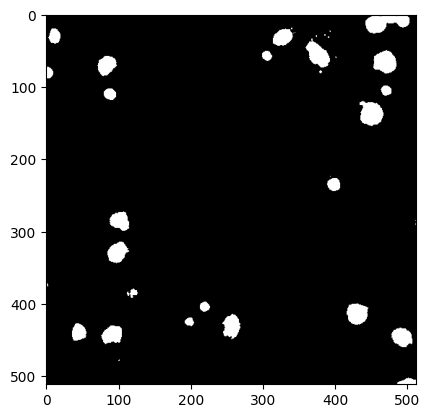

In [5]:
image_d=cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\CPvalid1_48_40x_Tiles_p0003DAPI.tif", flags =cv2.IMREAD_GRAYSCALE)
plt.imshow(image_d>11,cmap='gray')
plt.show()

In [ ]:
###code from https://github.com/TopologicalBird/Persistent_Homological_Figure_Detection_Segmentation/blob/main/Persistent_Homological_Figure_detection_segmentation.ipynb

In [8]:
%%time
BDsizethreshold=5#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours((image_d>11).astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=2#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=0.5#######threshold value for the persistence
boundary_death_positions=[]
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    for w in range (0,len(pairs)):
        if pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            boundary_death_positions.append([x,y,pairs[w].death_time()])
positionnumber=len(boundary_death_positions)
print(positionnumber, "figures detected")
center_position=np.array(boundary_death_positions)
CenterList=copy.deepcopy(center_position)

25 figures detected
CPU times: total: 31.2 ms
Wall time: 83.5 ms


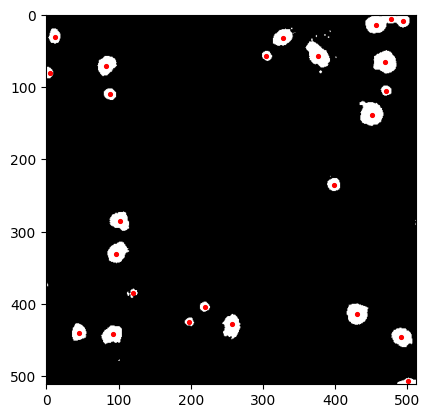

In [9]:
plt.imshow(image_d>11,cmap='gray')
plt.scatter(CenterList[:,0],CenterList[:,1], marker='.', s=30, c='red')
plt.show() #plot the points to see the data represent the original figure

# BBBC0008
## PH (using birth simplex) +watershed

In [11]:
image_f=cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\AS_09125_050116000001_L15f00d0_slice1_channel1.tif", flags =cv2.IMREAD_GRAYSCALE)

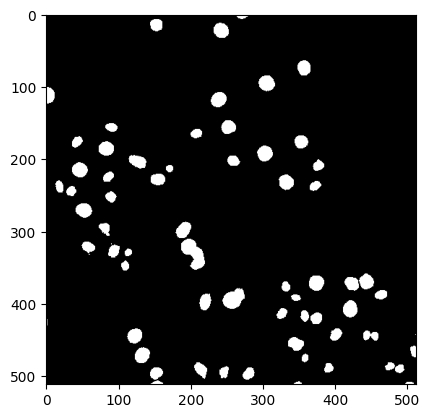

In [12]:
plt.imshow(image_f>20,cmap='gray')
plt.show()

In [ ]:
###code from https://github.com/TopologicalBird/Persistent_Homological_Figure_Detection_Segmentation/blob/main/Persistent_Homological_Figure_detection_segmentation.ipynb

In [13]:
%%time
ret, img_binary = cv2.threshold(image_f, 20, 255,cv2.THRESH_BINARY)
BDsizethreshold=5#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=4#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=0.5#######threshold value for the persistence
birth_threshold=0######birth threshold (We don't need a short segment on a single circle.)
img_binary_copy=copy.deepcopy(img_binary)
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True, save_phtrees=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    phtrees = pdlist.dth_diagram(1).load_phtrees()
    for w in range (0,len(pairs)):
        if pairs[w].birth_time()>birth_threshold and pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            node = phtrees.pair_node_nearest_to(pairs[w].birth_time(),pairs[w].death_time())
            birth_simplex_points=node.birth_simplex()
            cv2.line(img_binary_copy,
                     pt1=(int(birth_simplex_points[0][0]),int(birth_simplex_points[0][1])),
                     pt2=(int(birth_simplex_points[1][0]),int(birth_simplex_points[1][1])),
                     thickness=2,
                     color=(0,0,0),
                     lineType=cv2.LINE_8,
                     shift=0)

CPU times: total: 31.2 ms
Wall time: 203 ms


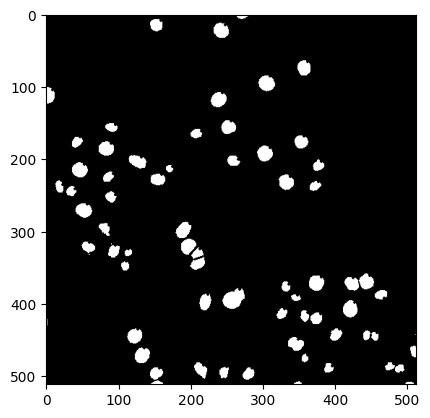

In [14]:
plt.imshow(img_binary_copy,cmap='gray')
plt.show()

In [15]:
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(img_binary_copy.astype('uint8'), connectivity=4)

In [16]:
#####making markers for watershed
####reduce small noise
from skimage.segmentation import watershed
markers=labels.astype('int32')
for k in range (0,len(stats)):
    if stats[k][4]<5:
        markers[np.where(markers==k)]=0

In [17]:
image_f2=cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\AS_09125_050116000001_L15f00d0_slice1_channel3.tif", flags =cv2.IMREAD_GRAYSCALE)

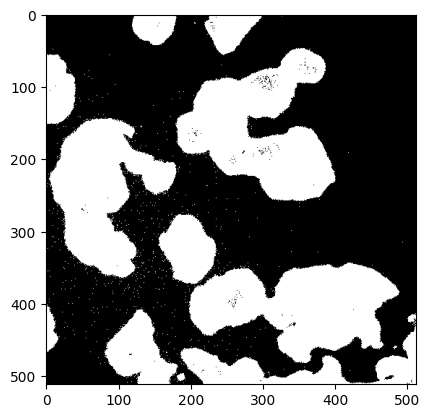

In [18]:
plt.imshow(image_f2>12,cmap='gray')
plt.show()

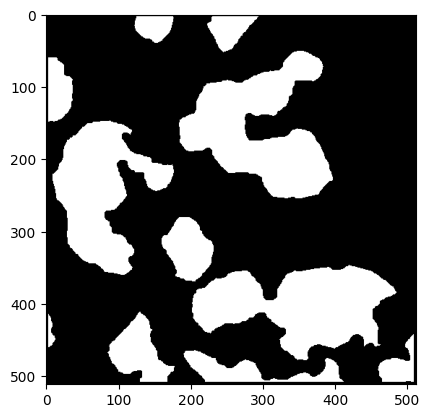

In [19]:
###External contour detection and mask construction
h,w=image_f2.shape
contours,hierarchy =cv2.findContours((image_f2>12).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
external_mask=np.zeros((h,w))
for j in range (0,len(contours)):
    if len(contours[j])>50:
        contour_points=np.array([[contours[j][k][0][1],contours[j][k][0][0]] for k in range (0,len(contours[j]))])
        contour_points_tr=np.transpose(contour_points)
        external_mask[(contour_points_tr[0],contour_points_tr[1])]=255
Y=external_mask<150
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(Y.astype('uint8'), connectivity=4)
connected_components_external=np.zeros((h,w))
too_large_area=100000
for l in range (0,np.max(labels)):
    labelIndex=l+1####
    spots=np.where(labels==labelIndex)
    if len(spots[0])<too_large_area:
        connected_components_external[spots]=255
eroded_mask=cv2.erode(connected_components_external,kernel=np.array([[1,1,1],[1,1,1],[1,1,1]],dtype='uint8'),iterations=2)
plt.imshow(eroded_mask,cmap='gray')
plt.show()

In [20]:
labels = watershed(image_f2, markers, mask=eroded_mask)

In [21]:
viewer=napari.view_image(image_f2)
viewer.add_image(labels)

Assistant skips harvesting pyclesperanto as it's not installed.


<Image layer 'labels' at 0x14bc0be0ee0>

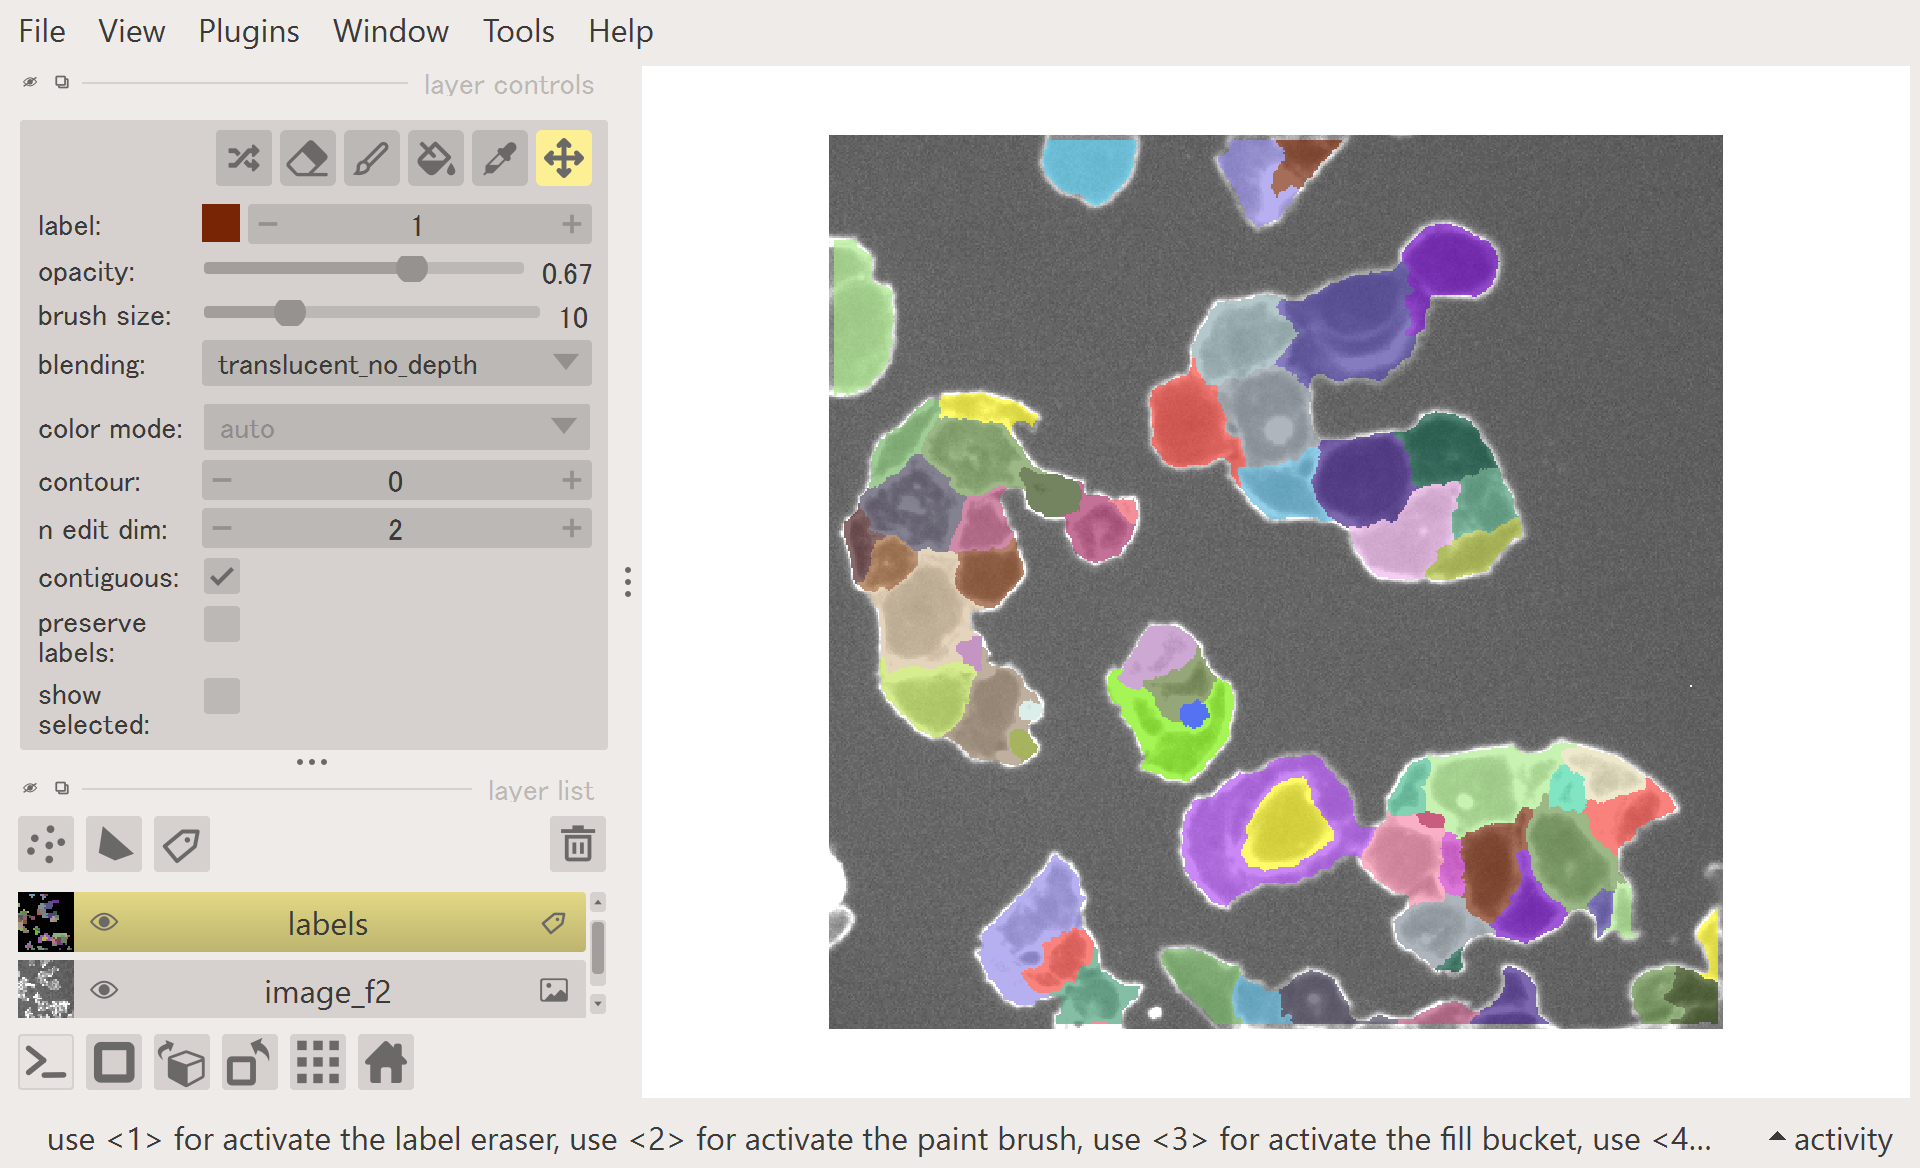

In [22]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

# BBC0038
## Easy to tune the results using persistence parameter

In [24]:
image= cv2.imread(r"D:\202404-projects\TAIATproject\BBBC0038\stage1_train\0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c\images\0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c.png", flags =cv2.IMREAD_GRAYSCALE)

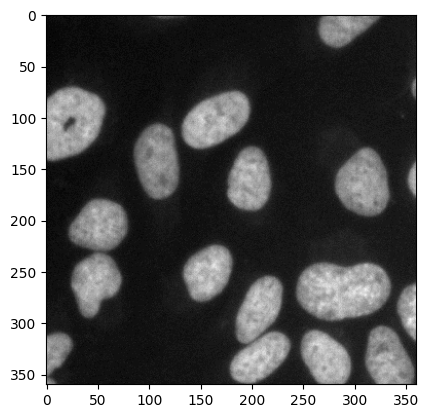

In [25]:
plt.imshow(image,cmap='gray')
plt.show()

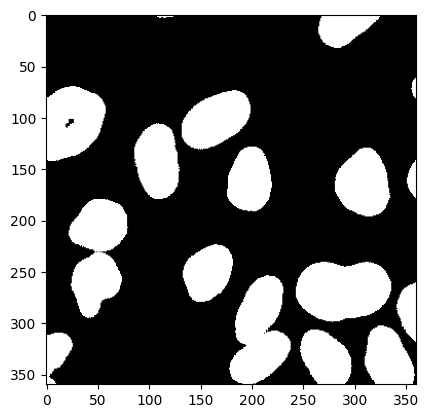

In [26]:
plt.imshow(image>10,cmap='gray')
plt.show()

In [31]:
%%time
BDsizethreshold=30#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours((image>10).astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=8#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=1#######threshold value for the persistence
boundary_death_positions=[]
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    for w in range (0,len(pairs)):
        if pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            boundary_death_positions.append([x,y,pairs[w].death_time()])
positionnumber=len(boundary_death_positions)
print(positionnumber, "figures detected")
center_position=np.array(boundary_death_positions)
CenterList=copy.deepcopy(center_position)

16 figures detected
CPU times: total: 141 ms
Wall time: 212 ms


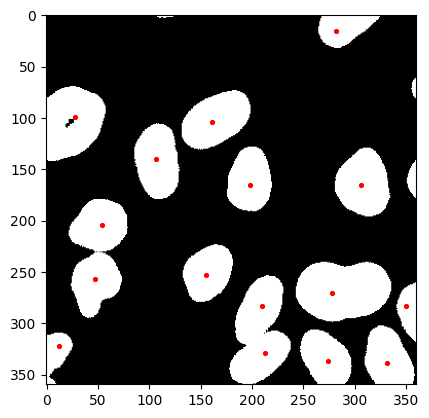

In [32]:
plt.imshow(image>10,cmap='gray')
plt.scatter(CenterList[:,0],CenterList[:,1], marker='.', s=30, c='red')
plt.show() #plot the points to see the data represent the original figure

In [33]:
%%time
BDsizethreshold=30#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours((image>10).astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=8#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=0.2#######threshold value for the persistence
boundary_death_positions=[]
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    for w in range (0,len(pairs)):
        if pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            boundary_death_positions.append([x,y,pairs[w].death_time()])
positionnumber=len(boundary_death_positions)
print(positionnumber, "figures detected")
center_position=np.array(boundary_death_positions)
CenterList=copy.deepcopy(center_position)

17 figures detected
CPU times: total: 31.2 ms
Wall time: 85.5 ms


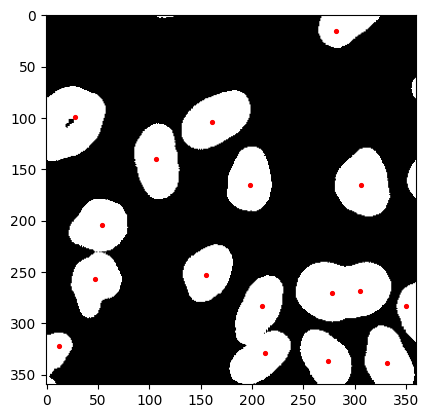

In [34]:
plt.imshow(image>10,cmap='gray')
plt.scatter(CenterList[:,0],CenterList[:,1], marker='.', s=30, c='red')
plt.show() #plot the points to see the data represent the original figure

# Image from https://doi.org/10.1093/bioinformatics/btu302
## Distance to measure transform vs usual signed distance transform

In [36]:
image_b = cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\image_tile_b.png", flags =cv2.IMREAD_GRAYSCALE)

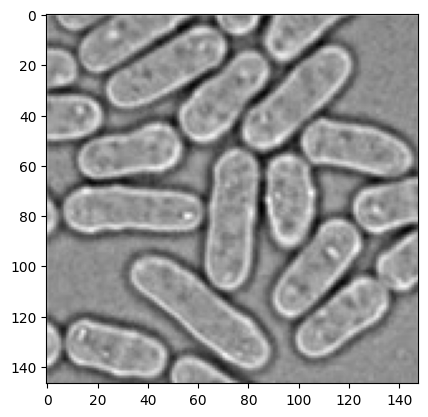

In [37]:
plt.imshow(image_b,cmap='gray')
plt.show()

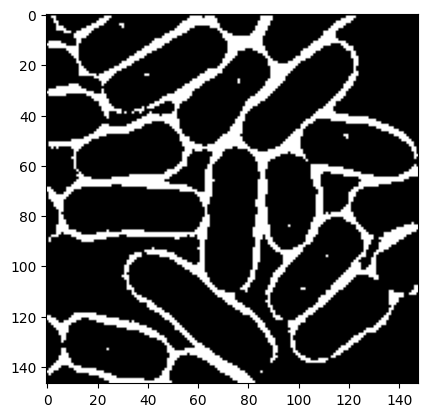

In [38]:
plt.imshow(image_b<100,cmap='gray')
plt.show()

In [39]:
####distance to measure transform
binary_img=image_b<100
thres=5
h,w=binary_img.shape
transformed_img=np.zeros((h,w))
dilate_kernel=np.array([[1,1,1],[1,1,1],[1,1,1]])
for k in range (0,h):
    print(k)
    for l in range (0,w):
        dilated_mask=np.zeros((h,w))
        dilated_mask[k,l]=1
        pixel_num=0
        r=0
        while pixel_num<thres:
            r=r+1
            dilated_mask=cv2.dilate(dilated_mask,dilate_kernel,iterations=1)
            pixel_num=np.sum(binary_img*dilated_mask)
        transformed_img[k,l]=r
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146


In [40]:
viewer=napari.view_image(transformed_img)
viewer.add_image(binary_img)

<Image layer 'binary_img' at 0x14bc8c9b670>

In [ ]:
###distance to measure transform result

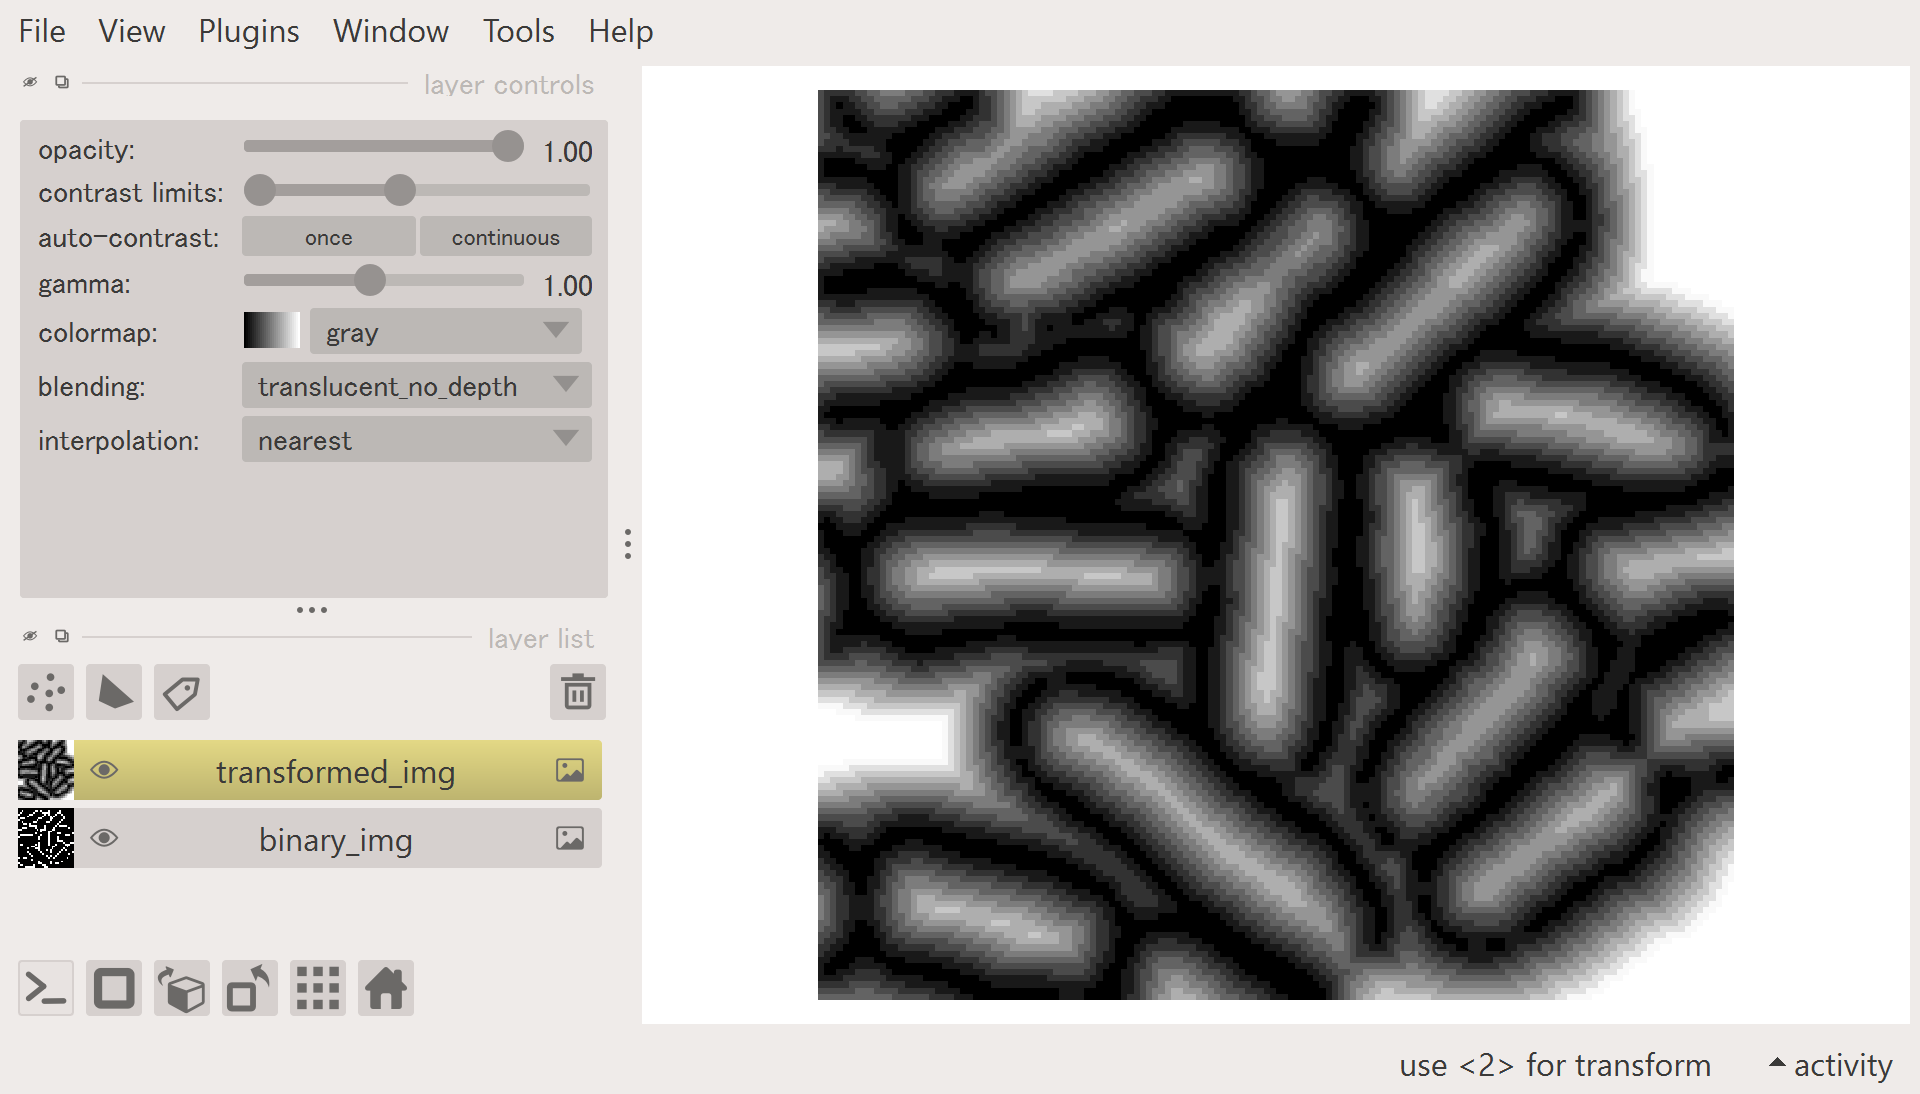

In [41]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

In [42]:
viewer2=napari.view_image(hc.distance_transform(binary_img,signed=True))

In [ ]:
###usual signed distance transform result

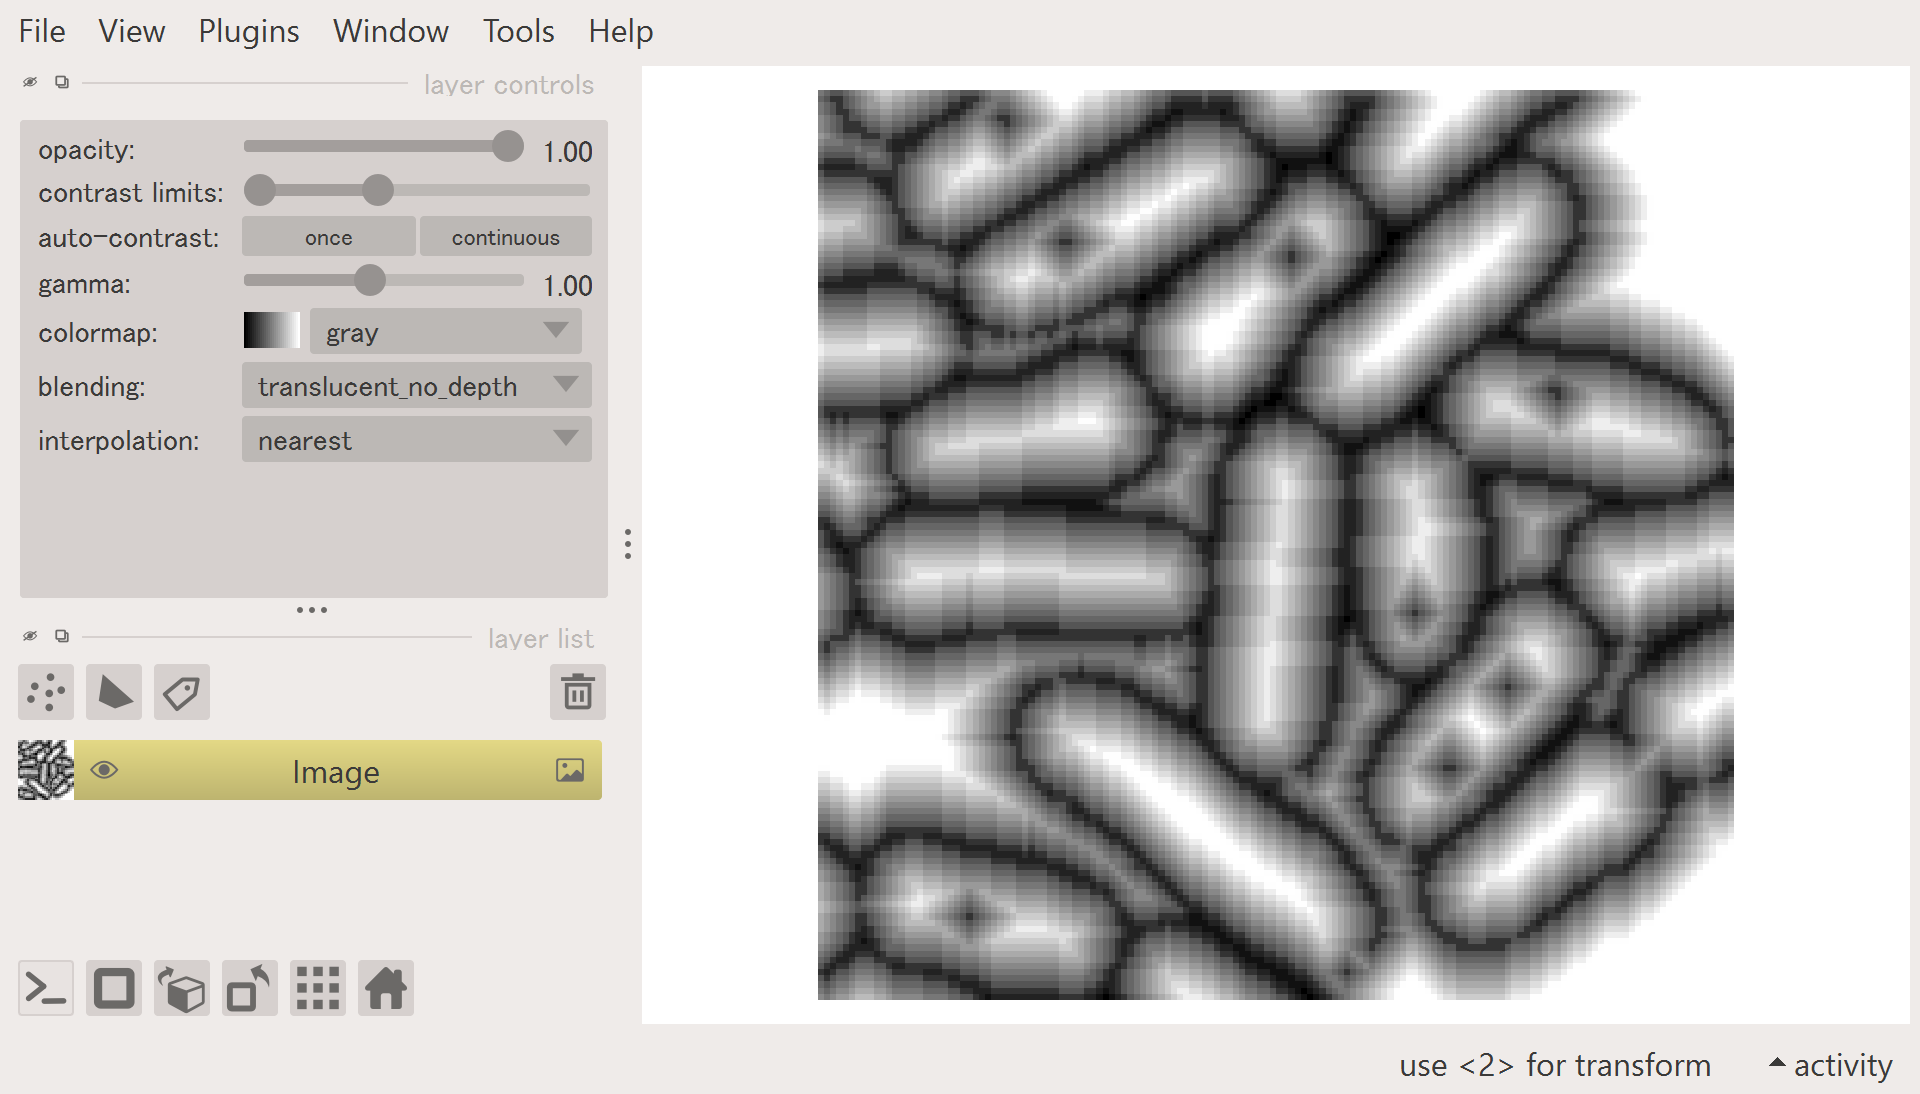

In [43]:
from napari.utils import nbscreenshot
nbscreenshot(viewer2)

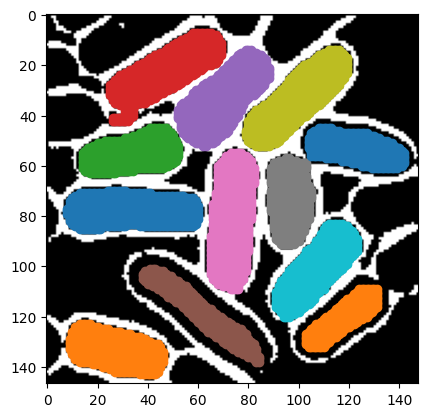

In [44]:
hc.BitmapPHTrees.for_bitmap_levelset(transformed_img, 
                                     save_to="binary-2d-tree.pdgm")
pdlist_with_tree = hc.PDList("binary-2d-tree.pdgm")
phtree_1 = pdlist_with_tree.bitmap_phtrees(1)
stable_volumes = [node.stable_volume(1) for node in phtree_1.nodes if node.death_time() > 7 and node.lifetime()>2]
plt.imshow(binary_img,cmap='gray')
for k in range (0,len(stable_volumes)):
    X=np.array(stable_volumes[k].volume())
    plt.scatter(X[:,1],X[:,0])
plt.show()

# BBBC0030
## Using with filter

In [45]:
image_cho=cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\cho48.png", flags =cv2.IMREAD_GRAYSCALE)

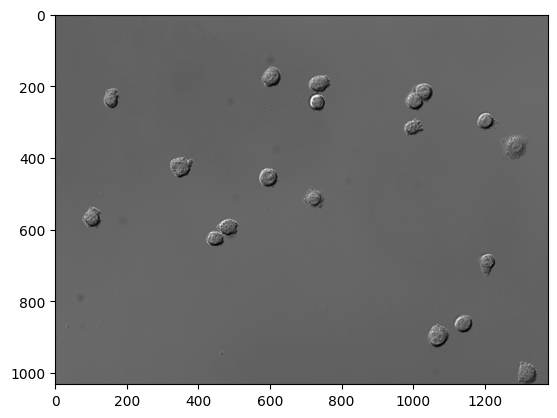

In [46]:
plt.imshow(image_cho,cmap='gray')
plt.show()

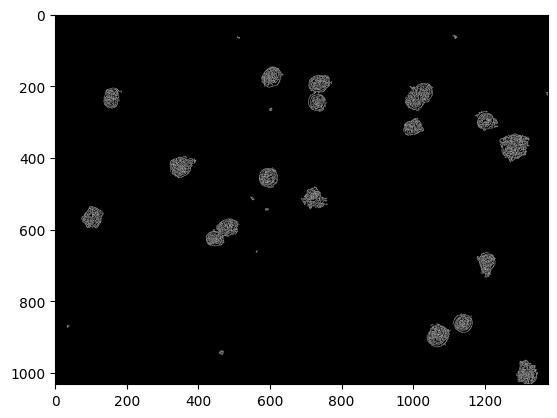

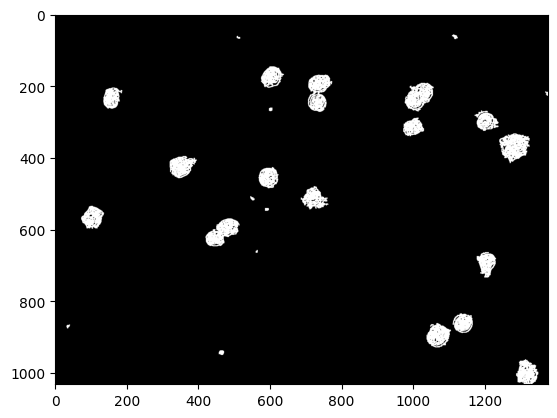

In [47]:
threshold1=10
threshold2=100
edge_img=cv2.Canny(image_cho, threshold1, threshold2)
plt.imshow(edge_img>0,cmap='gray')
plt.show()
dilated_edge=cv2.dilate(edge_img,kernel=np.array([[1,1,1],[1,1,1],[1,1,1]],dtype='uint8'),iterations=1)
plt.imshow(dilated_edge,cmap='gray')
plt.show()

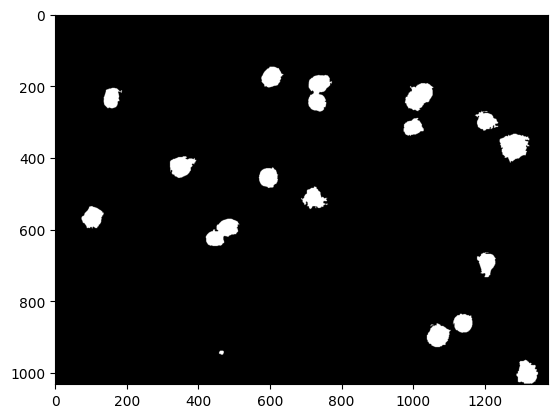

In [48]:
h,w=dilated_edge.shape
too_small_area=100
too_large_area=10000
contours,hierarchy =cv2.findContours(dilated_edge.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
external_mask=np.zeros((h,w))
for j in range (0,len(contours)):
    contour_points=np.array([[contours[j][k][0][1],contours[j][k][0][0]] for k in range (0,len(contours[j]))])
    contour_points_tr=np.transpose(contour_points)
    external_mask[(contour_points_tr[0],contour_points_tr[1])]=255
Y=external_mask<150
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(Y.astype('uint8'), connectivity=4)
connected_components_external=np.zeros((h,w))
for l in range (0,np.max(labels)):
    labelIndex=l+1####
    spots=np.where(labels==labelIndex)
    if too_small_area<len(spots[0])<too_large_area:
        connected_components_external[spots]=255
plt.imshow(connected_components_external,cmap='gray')
plt.show()

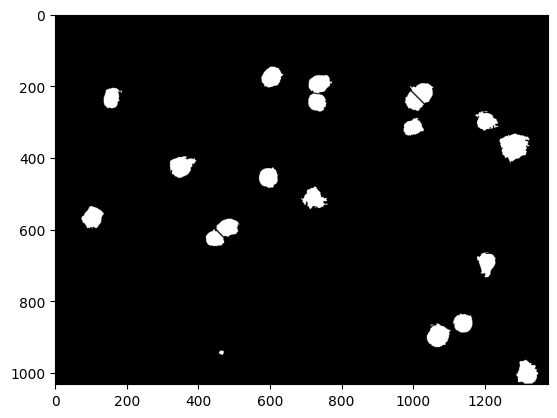

CPU times: total: 219 ms
Wall time: 409 ms


In [49]:
%%time
ret, img_binary = cv2.threshold(connected_components_external.astype('uint8'), 150, 255,cv2.THRESH_BINARY)
BDsizethreshold=5#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=10#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=0.5#######threshold value for the persistence
birth_threshold=1######birth threshold (We don't need a short segment on a single circle.)
img_binary_copy=copy.deepcopy(img_binary)
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True, save_phtrees=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    phtrees = pdlist.dth_diagram(1).load_phtrees()
    for w in range (0,len(pairs)):
        if pairs[w].birth_time()>birth_threshold and pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            node = phtrees.pair_node_nearest_to(pairs[w].birth_time(),pairs[w].death_time())
            birth_simplex_points=node.birth_simplex()
            cv2.line(img_binary_copy,
                     pt1=(int(birth_simplex_points[0][0]),int(birth_simplex_points[0][1])),
                     pt2=(int(birth_simplex_points[1][0]),int(birth_simplex_points[1][1])),
                     thickness=2,
                     color=(0,0,0),
                     lineType=cv2.LINE_8,
                     shift=0)
plt.imshow(img_binary_copy,cmap='gray')
plt.show()

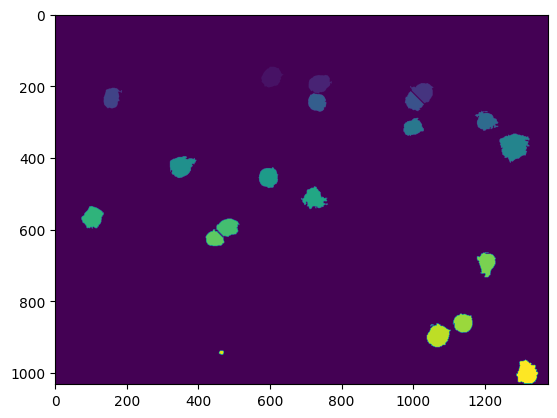

In [50]:
ret, bin_img = cv2.threshold(img_binary_copy, 20, 255, cv2.THRESH_BINARY)
n_labels, labels = cv2.connectedComponents(bin_img)
plt.imshow(labels)
plt.show()

In [51]:
viewer=napari.view_image(image_cho)
viewer.add_image(labels)

<Image layer 'labels' at 0x14bdeb233d0>

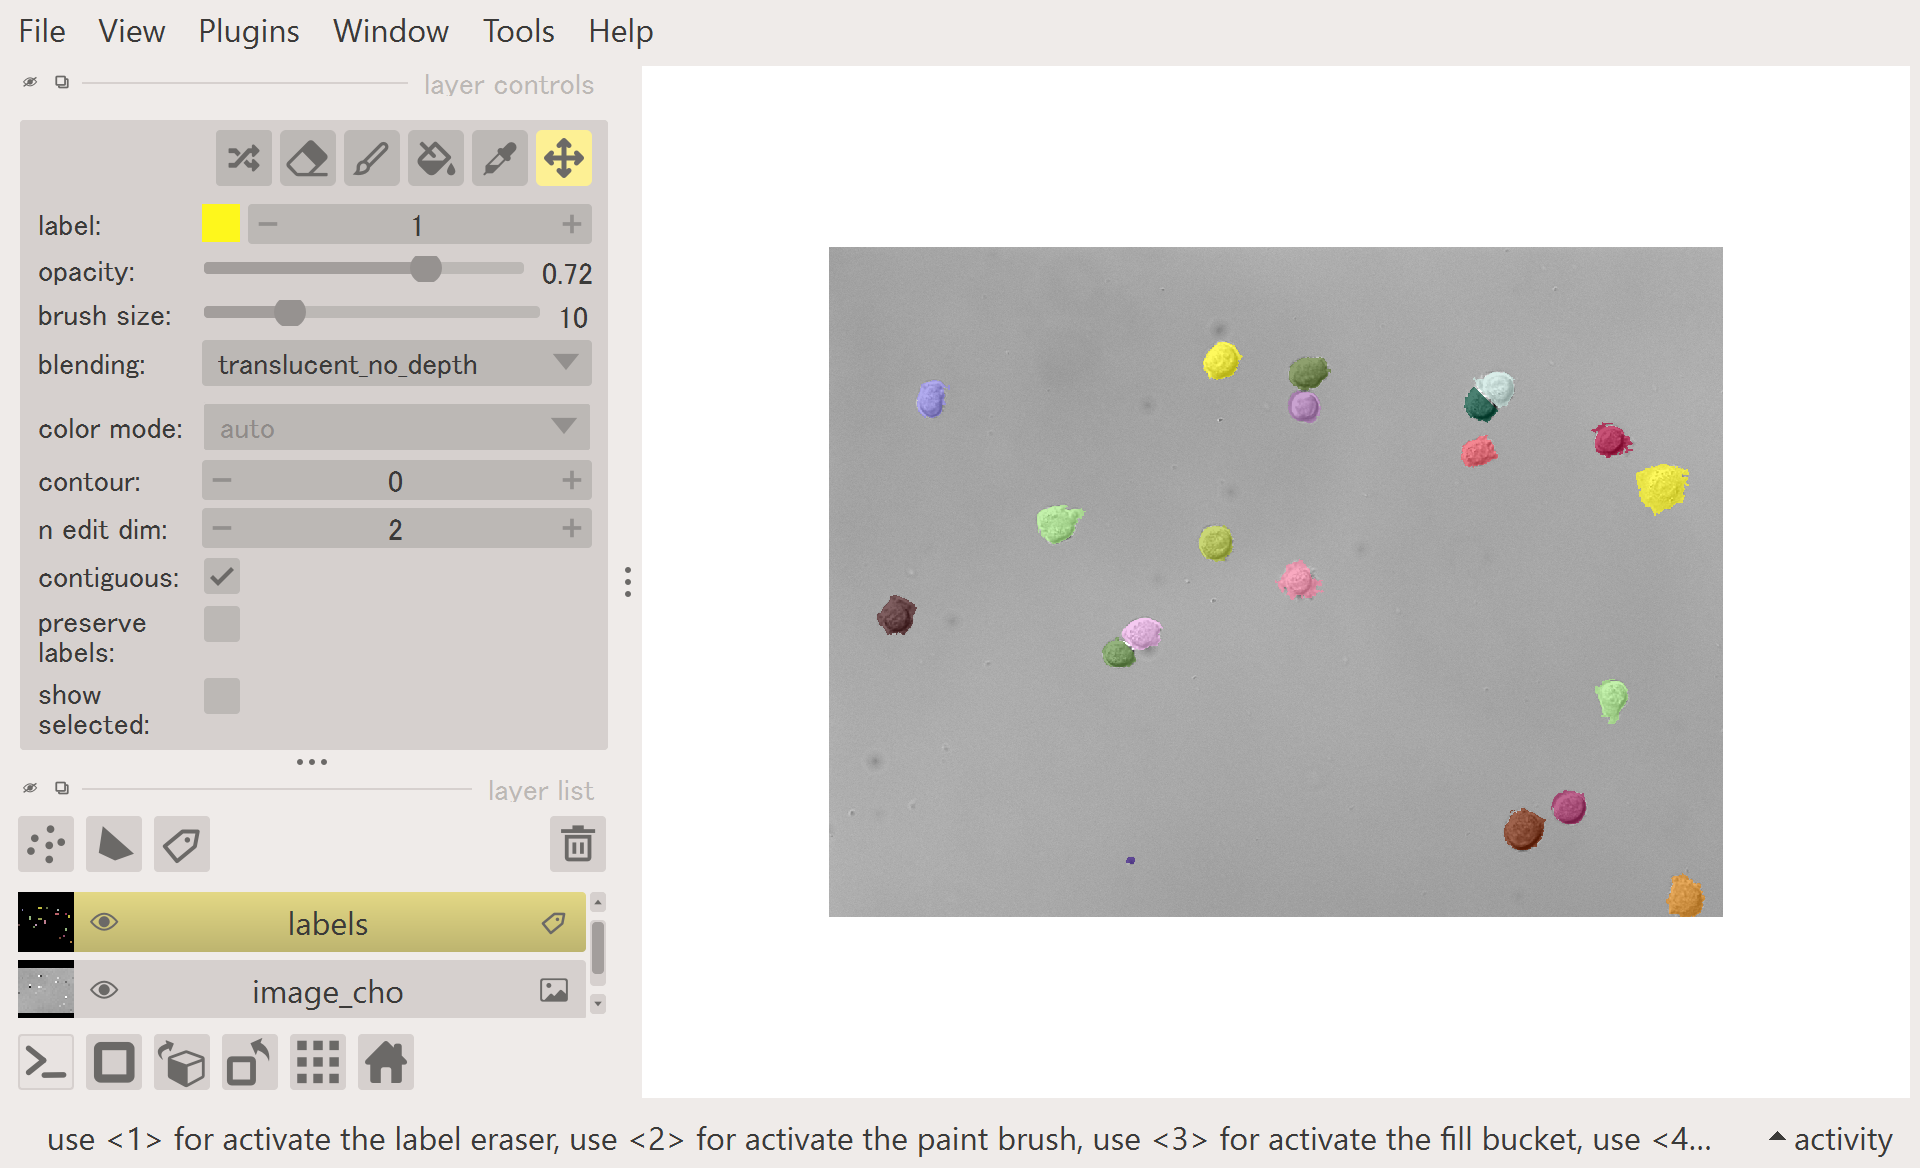

In [52]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

# BBBC0038
## Using with filter

In [53]:
image= cv2.imread(r"D:\202404-projects\TAIATproject\BBBC0038\stage1_train\0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e\images\0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e.png", flags =cv2.IMREAD_GRAYSCALE)

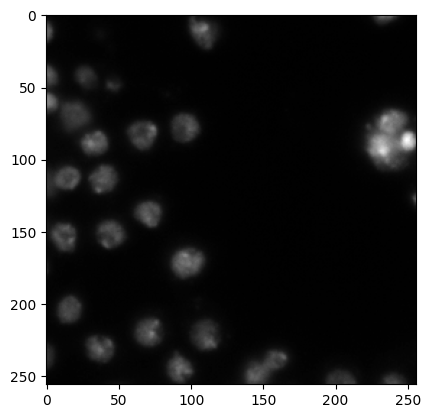

In [54]:
plt.imshow(image,cmap='gray')
plt.show()

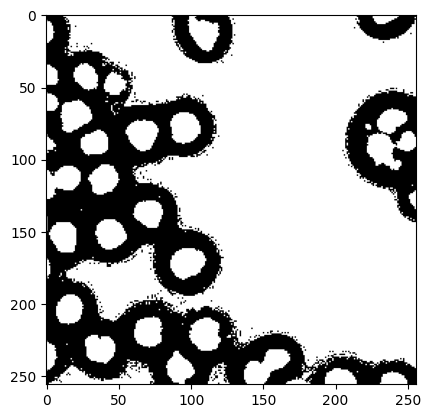

In [55]:
dst2 = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 41, 2)
plt.imshow(dst2,cmap='gray')
plt.show()

In [56]:
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(dst2.astype('uint8'), connectivity=4)

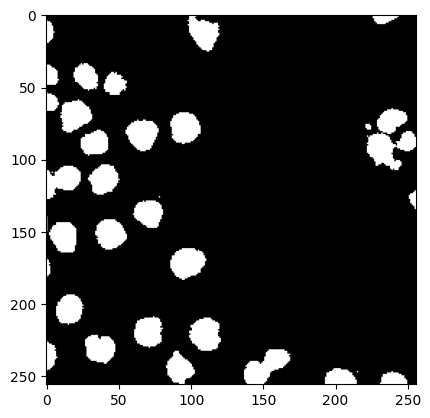

In [57]:
h,w=image.shape
whiteratiothres=0.7
binthres=10
maskimg=np.zeros((h,w))
for i in range (0,np.max(labels)):
    labelIndex=i+1
    spots=np.where(labels==labelIndex)
    if np.sum((image>binthres)[spots])/len(spots[0])>whiteratiothres:
        maskimg[spots]=1
plt.imshow(maskimg,cmap='gray')
plt.show()

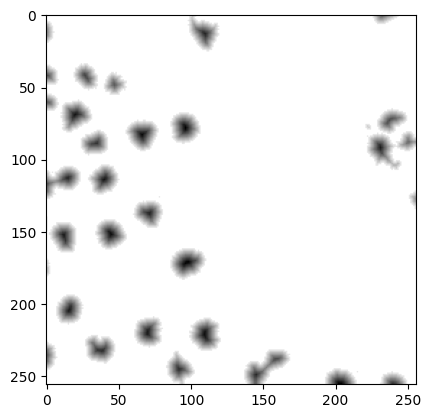

In [70]:
from scipy import ndimage
edt_img=ndimage.distance_transform_edt(maskimg)
plt.imshow(-edt_img,cmap='gray')
plt.show()

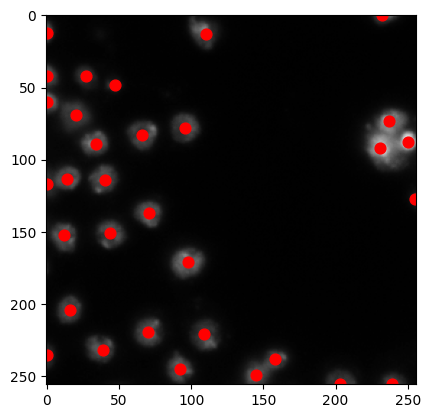

31


In [71]:
hc.PDList.from_bitmap_levelset(-edt_img, save_to="binary-image-edt.pdgm")
pdlist = hc.PDList("binary-image-edt.pdgm")
pd0=pdlist.dth_diagram(0)
figures=[pair for pair in pd0.pairs() if pair.birth<-4 and pair.lifetime()>1]
plt.imshow(image,cmap='gray')
for i in range (0,len(figures)):
    marker_pos=figures[i].birth_position
    plt.scatter(marker_pos[1],marker_pos[0],s=60,c='red')
ess_pos=pd0.essential_birth_positions[0]
plt.scatter(ess_pos[1],ess_pos[0],s=60,c='red')
plt.show()
print(len(figures))

# BBBC0038
## Using with filter

In [72]:
image= cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21\images\0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21.png", flags =cv2.IMREAD_GRAYSCALE)

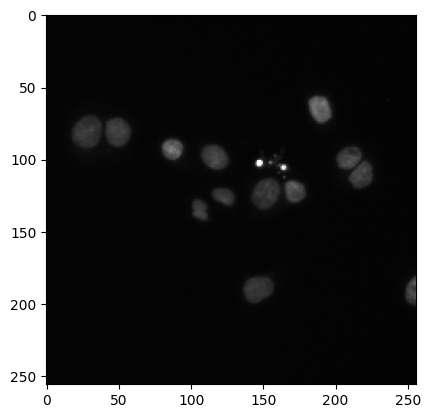

In [73]:
plt.imshow(image,cmap='gray')
plt.show()

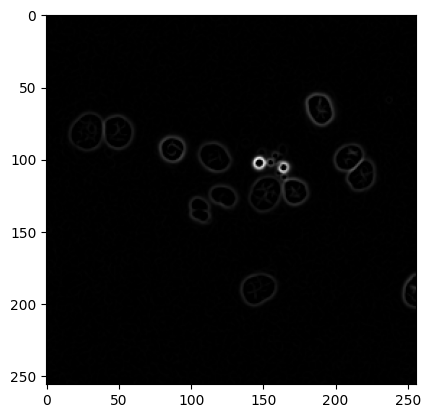

In [74]:
from skimage import filters
filtered_img=filters.sato(image,sigmas=range(1,2,1),black_ridges=True,mode='reflect',cval=0)
plt.imshow(filtered_img,cmap='gray')
plt.show()

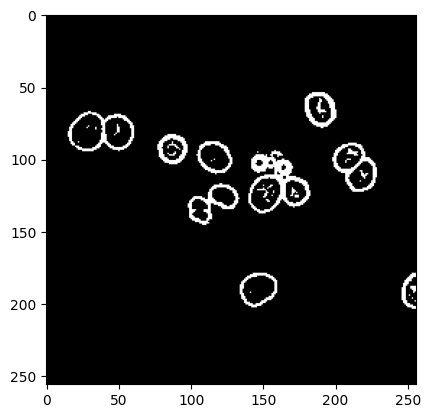

In [75]:
plt.imshow(filtered_img>2,cmap='gray')
plt.show()

In [76]:
###we did pre-processing for PH analysis

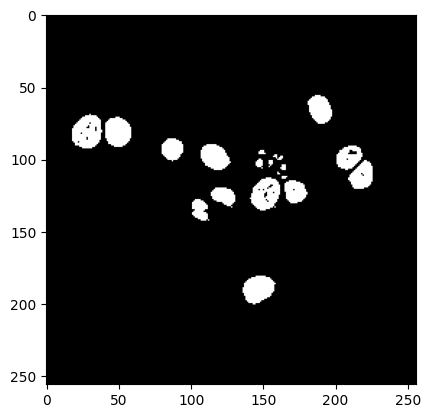

In [77]:
hc.BitmapPHTrees.for_bitmap_levelset(filtered_img,"superlevel" ,
                                     save_to="grayscale-tree.pdgm")
phtrees = hc.PDList("grayscale-tree.pdgm").bitmap_phtrees(1)
h,w=filtered_img.shape
lifeThres=1
epsilon=0
mask=np.zeros((h,w))
count=0
for k in range (0,len(phtrees.nodes)):
    node=phtrees.nodes[k]
    if node.lifetime()<-lifeThres:
        spots=np.array(node.stable_volume(epsilon).volume())
        spots_tr=np.transpose(spots)
        mask[(spots_tr[0],spots_tr[1])]=255
        count=count+1
plt.imshow(mask,cmap='gray')
plt.show()

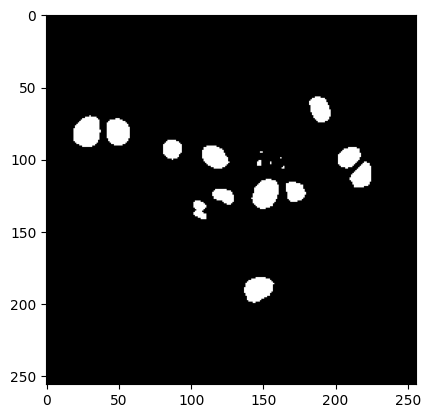

In [79]:
too_large_area=1000
contours,hierarchy =cv2.findContours(mask.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
external_mask=np.zeros((h,w))
for j in range (0,len(contours)):
    contour_points=np.array([[contours[j][k][0][1],contours[j][k][0][0]] for k in range (0,len(contours[j]))])
    contour_points_tr=np.transpose(contour_points)
    external_mask[(contour_points_tr[0],contour_points_tr[1])]=255
Y=external_mask<150
n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(Y.astype('uint8'), connectivity=4)
connected_components_external=np.zeros((h,w))
for l in range (0,np.max(labels)):
    labelIndex=l+1####
    spots=np.where(labels==labelIndex)
    if len(spots[0])<too_large_area:
        connected_components_external[spots]=255
plt.imshow(connected_components_external,cmap='gray')
plt.show()

In [86]:
%%time
BDsizethreshold=10#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours(connected_components_external.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=2#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=0.5#######threshold value for the persistence
boundary_death_positions=[]
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    for w in range (0,len(pairs)):
        if pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            boundary_death_positions.append([x,y,pairs[w].death_time()])
positionnumber=len(boundary_death_positions)
print(positionnumber, "figures detected")
center_position=np.array(boundary_death_positions)
CenterList=copy.deepcopy(center_position)

13 figures detected
CPU times: total: 15.6 ms
Wall time: 96.1 ms


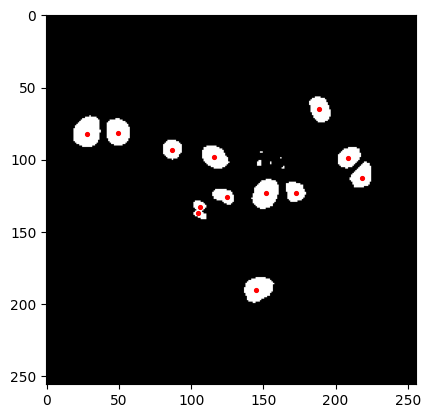

In [87]:
plt.imshow(connected_components_external.astype('uint8'),cmap='gray')
plt.scatter(CenterList[:,0],CenterList[:,1], marker='.', s=30, c='red')
plt.show() #plot the points to see the data represent the original figure

# Image from https://doi.org/10.1093/bioinformatics/btu302
## Using with filter
## Trying different paths

In [88]:
image = cv2.imread(r"D:\202404-projects\TAIATproject\additional_data_for_paper\image_tile_a.png", flags =cv2.IMREAD_GRAYSCALE)

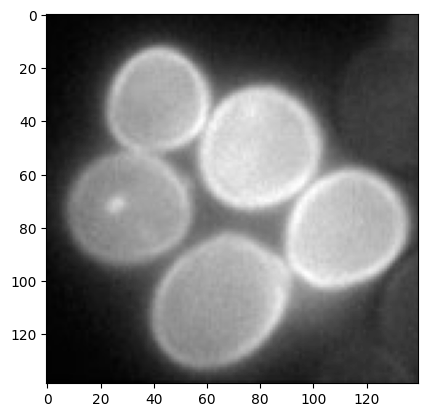

In [89]:
plt.imshow(image,cmap='gray')
plt.show()

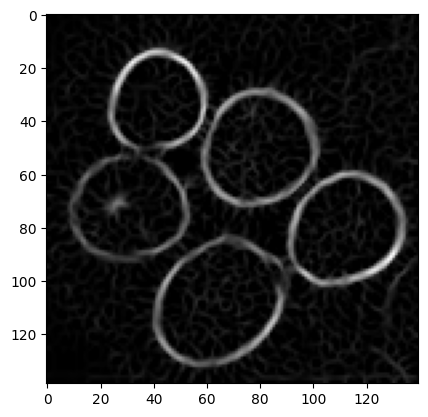

In [90]:
from skimage import filters
filtered_img=filters.sato(image,sigmas=range(1,2,1),black_ridges=False,mode='reflect',cval=0)
plt.imshow(filtered_img,cmap='gray')
plt.show()

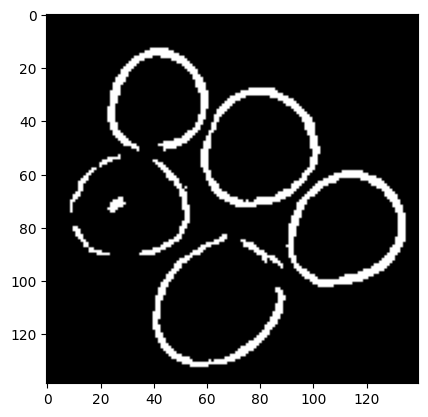

In [91]:
plt.imshow(filtered_img>5,cmap='gray')###If we set this threshold as 4, we get easier image. Here, for demonstration, we use 5.
plt.show()

In [93]:
binary=filtered_img>5
pointcloud=np.transpose(np.array([np.where(binary)[0],np.where(binary)[1]]))
hc.PDList.from_alpha_filtration(pointcloud, 
                                save_to="pointcloud-phtrees.pdgm",
                                no_squared=True,
                                save_phtrees=True,
                                save_boundary_map=True)
phtrees = hc.PDList("pointcloud-phtrees.pdgm").dth_diagram(1).load_phtrees()
stable_volumes = [node.stable_volume(0.01) for node in phtrees.all_nodes if node.death_time() > 10 and node.lifetime()>1]

In [94]:
h,w=binary.shape
connected_img=np.zeros((h,w))
for sv in stable_volumes:
    boundary_edges=sv.boundary()
    for i in range (0,len(boundary_edges)):
        cv2.line(connected_img,
                     pt1=(int(boundary_edges[i][0][1]),int(boundary_edges[i][0][0])),
                     pt2=(int(boundary_edges[i][1][1]),int(boundary_edges[i][1][0])),
                     thickness=1,
                     color=(255,255,255),
                     lineType=cv2.LINE_8,
                     shift=0)

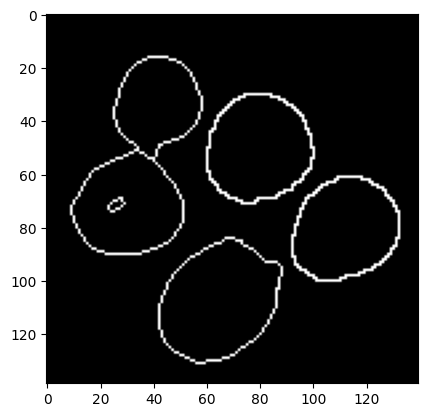

In [95]:
plt.imshow(connected_img,cmap='gray')
plt.show()

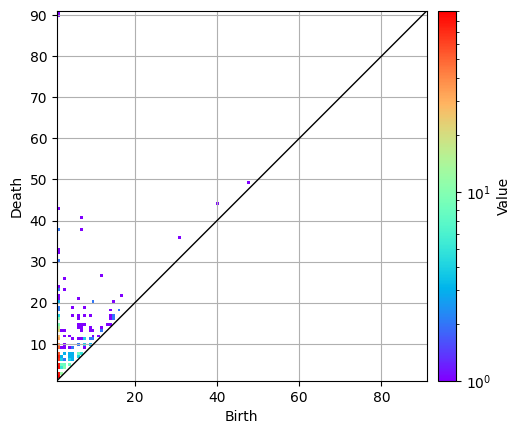

In [96]:
###grayscale filtration
pict=filtered_img*255/np.max(filtered_img)
h,w=pict.shape
pict_16=copy.deepcopy(pict)
pict_16=pict_16.astype('uint16')
pict_16=pict_16+1
pict_16[1,1]=0####Background should go to the essential class.
hc.BitmapPHTrees.for_bitmap_levelset(pict_16, "sublevel", save_to="grayscale2-tree.pdgm")
phtrees2 = hc.PDList("grayscale2-tree.pdgm").bitmap_phtrees(0)
pdlist_with_tree = hc.PDList("grayscale2-tree.pdgm")
pd0=pdlist_with_tree[0]
pd0.histogram().plot(colorbar={"type": "log"})

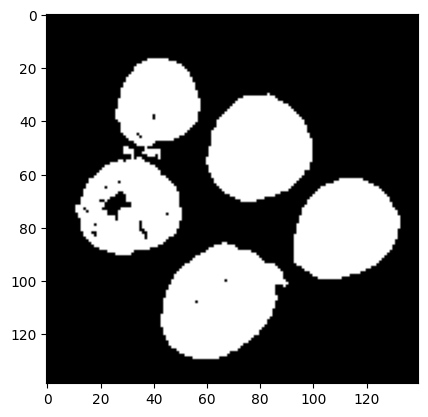

In [97]:
h,w=filtered_img.shape
lifethres=25#####Threshold value for the persistence
volumethres=500#####Threshold value for the volume size to be detected
too_large_area=20000
pict=filtered_img*255/np.max(filtered_img)
h,w=pict.shape
sample_detected_mask=np.zeros((h,w))
pict_16=copy.deepcopy(pict)
pict_16=pict_16.astype('uint16')
pict_16=pict_16+1
pict_16[1,1]=0####Background should go to the essential class.
hc.BitmapPHTrees.for_bitmap_levelset(pict_16, "sublevel", save_to="grayscale2-tree.pdgm")
phtrees2 = hc.PDList("grayscale2-tree.pdgm").bitmap_phtrees(0)
nodes = [node for node in phtrees2.nodes if node.lifetime() > lifethres and node.death_time() != np.inf and len(node.volume())>volumethres]
for i in range (0,len(nodes)):
    detected_mask=np.zeros((h,w))
    mask_spots=tuple(np.transpose(np.array(nodes[i].volume())).tolist())
    detected_mask[mask_spots]=255
    if len(np.where(detected_mask)[0])<too_large_area and detected_mask[0,0]==0 and detected_mask[h-1,0]==0 and detected_mask[0,w-1]==0 and detected_mask[h-1,w-1]==0:####
        sample_detected_mask[np.where(detected_mask)]=255
plt.imshow(sample_detected_mask,cmap='gray')
plt.show()

# Image from https://github.com/BiAPoL/HIP_Introduction_to_Napari_and_image_processing_with_Python_2022/tree/main
## 3D image analysis

In [98]:
image = cv2.imreadmulti(r"D:\202404-projects\TAIATproject\additional_data_for_paper\nuclei.tif", flags =cv2.IMREAD_UNCHANGED)
imageSlices=image[1]

In [99]:
imageSlices=np.array(imageSlices)

In [100]:
from scipy import ndimage
filtered_img=ndimage.gaussian_filter(imageSlices, sigma=5)

In [101]:
binary_img=filtered_img>9500
edt_image=ndimage.distance_transform_edt(binary_img)
viewer5=napari.view_image(edt_image)

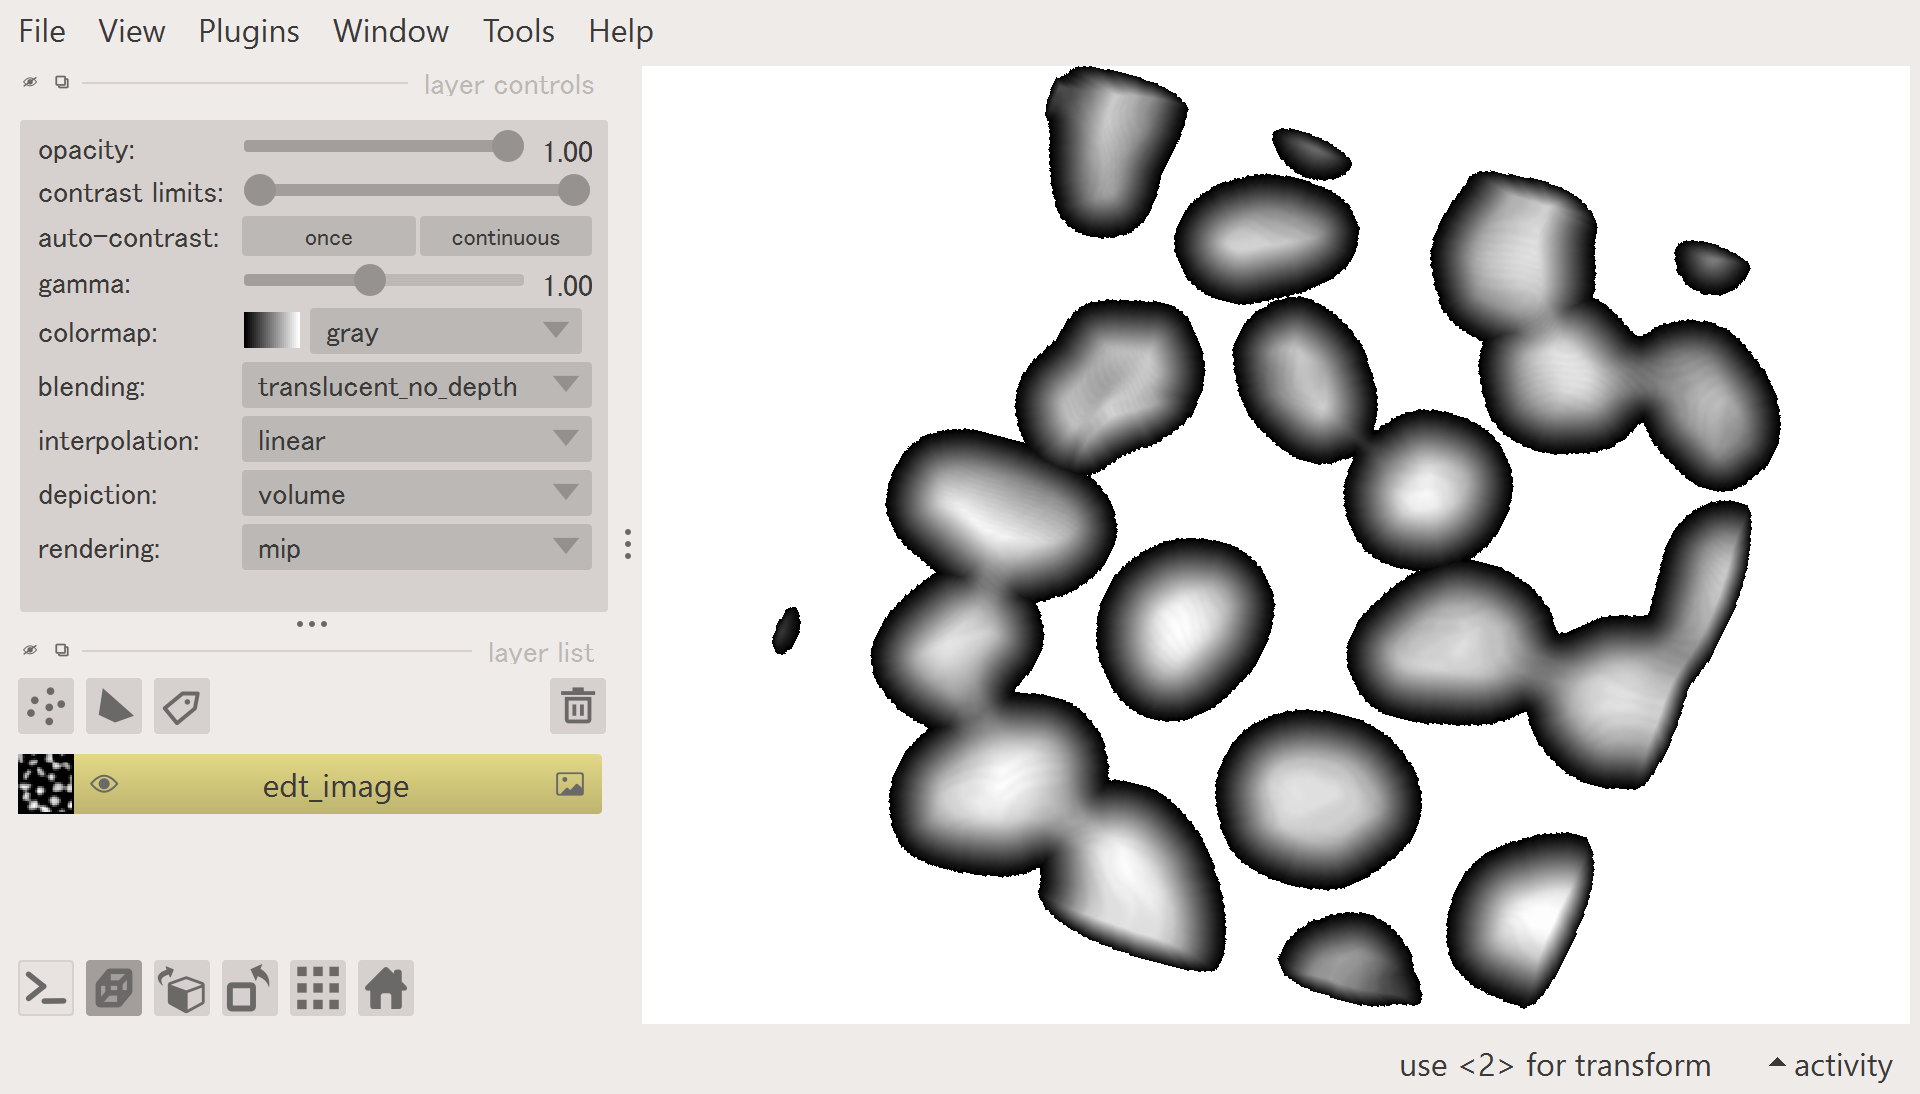

In [103]:
from napari.utils import nbscreenshot
nbscreenshot(viewer5)

In [104]:
hc.PDList.from_bitmap_levelset(-edt_image, save_to="3d-binary-image-edt.pdgm")

PDList(path=3d-binary-image-edt.pdgm)

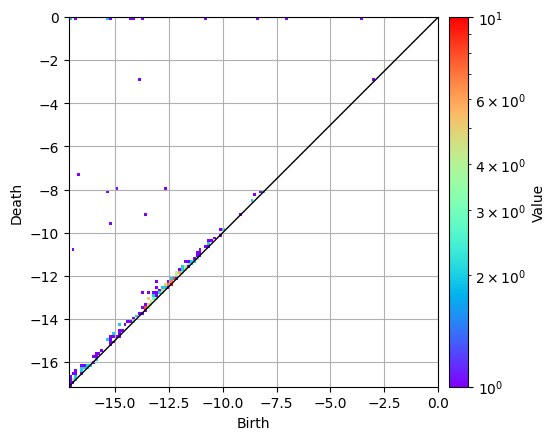

In [105]:
pdlist = hc.PDList("3d-binary-image-edt.pdgm")
pd0=pdlist.dth_diagram(0)
pd0.histogram().plot(colorbar={"type":"log"})

In [106]:
figures=[pair.birth_position for pair in pd0.pairs() if pair.lifetime()>1]
ess_birth_pos=pd0.essential_birth_positions[0]
figures.append(ess_birth_pos)

In [107]:
len(figures)

22

In [109]:
viewer5.add_points(figures)

<Points layer 'Points' at 0x14c122f4910>

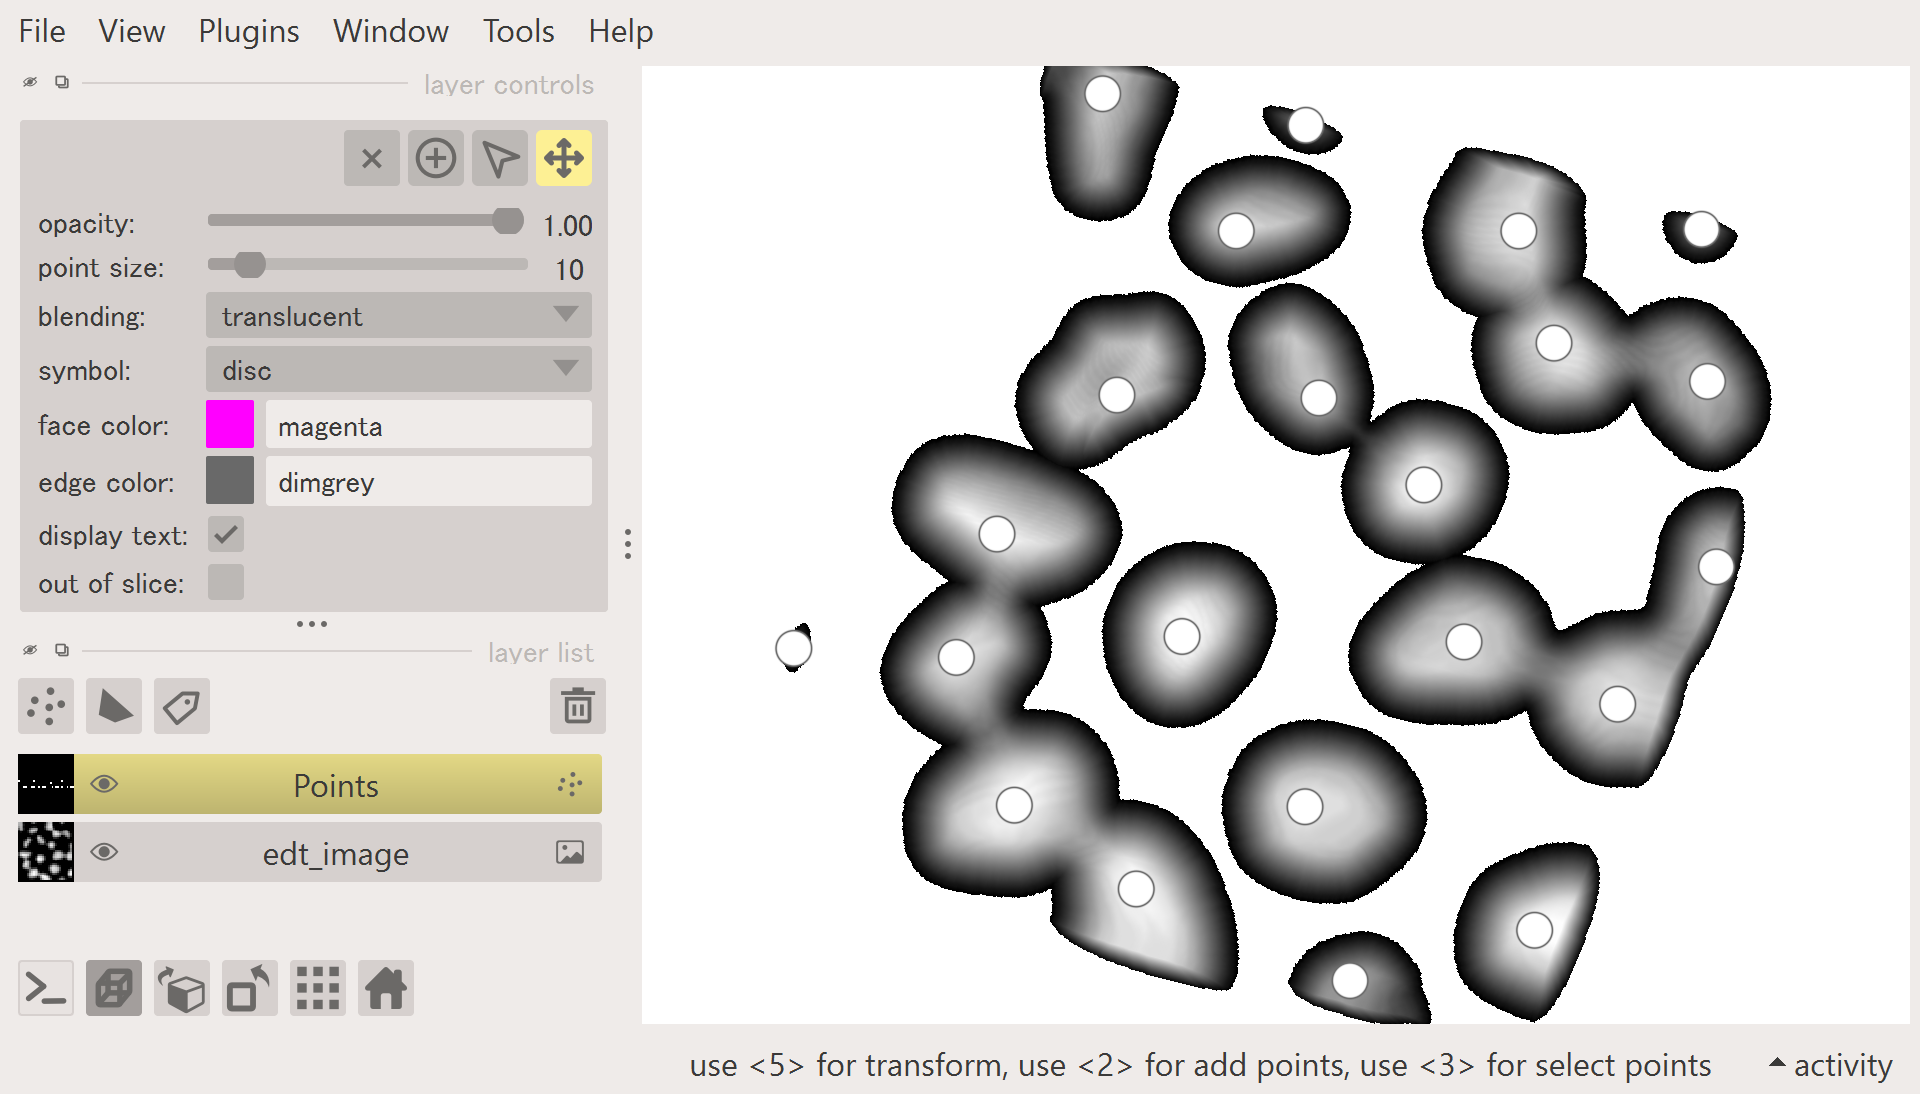

In [110]:
from napari.utils import nbscreenshot
nbscreenshot(viewer5)